# Prepare data

In [42]:
from pathlib import Path
from openpyxl import Workbook, load_workbook  # type: ignore
import os



def to_excel(
    data, filename, sheet_style, result_dir_path, new_sheet=False, sheet_name="Sheet1"
):

    if not os.path.exists(result_dir_path):
        os.makedirs(result_dir_path, exist_ok=True)

    file_path = os.path.join(result_dir_path, f"{filename}.xlsx")

    if os.path.exists(file_path):
        workbook = load_workbook(file_path)
        if new_sheet:
            sheet = workbook.create_sheet(title=sheet_name)

        else:
            sheet = workbook.active
    else:
        workbook = Workbook()
        default_sheet = workbook.active
        workbook.remove(default_sheet)
        sheet = workbook.create_sheet(title=sheet_name)
        
    if sheet_style:
        sheet.append(sheet_style)


    if new_sheet:
        print(data)
    # write data into file
    for row in data:
        sheet.append(row)

    workbook.save(filename=f"{result_dir_path}\\{filename}.xlsx")



# read input dataset
filename_prefix = (
    "RANDclient_test-DTWedSep251926542024"
)


dataset_read_filename = filename_prefix
training_data_dir = Path.cwd().parent.parent / "training_data"


# Data preprocessing
file_path = f"{training_data_dir}\\{dataset_read_filename}.xlsx"



# set result output filename and path
result_suffix = "result"

result_dir_path = Path.cwd().parent.parent / "results" / "result_processTime_waitTasks_v1"

if not os.path.exists(result_dir_path):
    os.makedirs(result_dir_path)

version_index = len([_ for _ in Path(result_dir_path).iterdir() if _.is_file()])
version = f"_v{version_index}"

result_name = "processTime#waitTasks" + version
result_output_filename = f"{filename_prefix}{result_name}{result_suffix}"

In [43]:

import pandas as pd # type: ignore
import numpy as np # type: ignore


def read_data(filename):
    df = pd.read_excel(filename)
    columns = df.columns.to_list()
    data_dict = {col: df[col].to_list() for col in columns}
    return data_dict


def data_preprocess(filepath):
    data = read_data(filepath)
    # TODO more...

    # to numpy
    for key in data.keys():
        data[key] = np.array(data[key])

    return data

In [44]:
dataset = data_preprocess(file_path)

## Split dataset

In [45]:
y = np.array(dataset.get("worker_wait_time"))

_X = np.array([dataset.get("request_num"), dataset.get(
    "jobs_on_worker_node"), dataset.get('processed_time')])

# Preprocess Data

In [46]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Convert _X to a NumPy array and transpose it if necessary
X = _X.T  # Shape will be (num_samples, num_features)

# Reshape y to be a 2D array
y = np.array(y).reshape(-1, 1)

# Normalize the data to [0, 1] range
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y)


# Create sequences for LSTM
def create_sequences(X, y, time_step):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:i + time_step])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

time_step = 5  # Number of time steps in each sequence
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_step)




## Split train, valid, test

In [47]:
from sklearn.model_selection import train_test_split

# Define the split ratios
test_ratio = 0.2
val_ratio = 0.3

# Split into train+val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_seq, y_seq, test_size=test_ratio, shuffle=True)

# Split the train+val set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio, shuffle=True)

# LSTM

## fit

In [48]:
import tensorflow as tf                                     # type: ignore
from tensorflow.keras.models import Sequential              #  type: ignore
from tensorflow.keras.layers import LSTM, Dense, Input             #  type: ignore

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(time_step, X_seq.shape[2])))
model.add(LSTM(units=100, return_sequences=True))  
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
)

model.save(str(Path.cwd().parent / 'modelsfile/LSTM_tasks_time.keras'))

Epoch 1/50


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1433 - val_loss: 0.0285
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0277 - val_loss: 0.0090
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0030
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0015

## predict


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


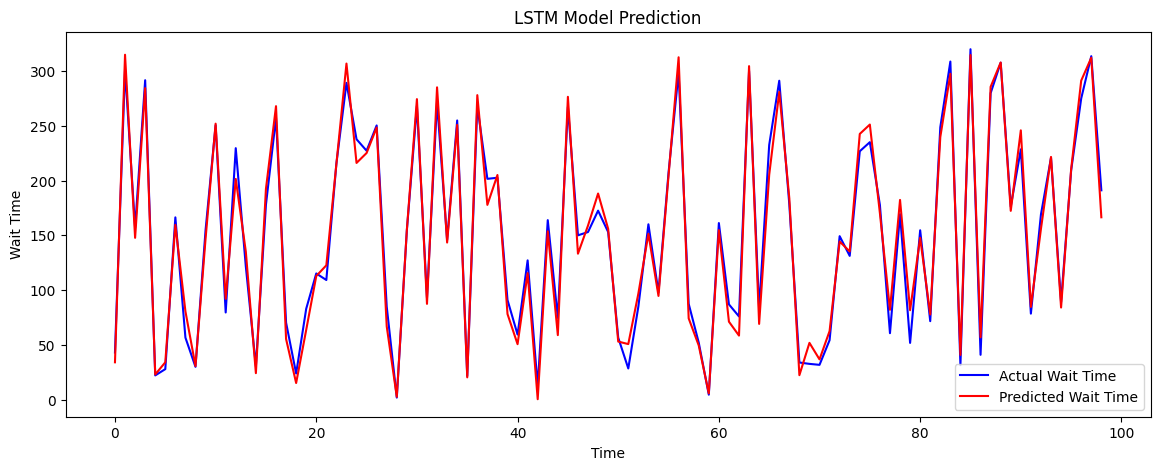

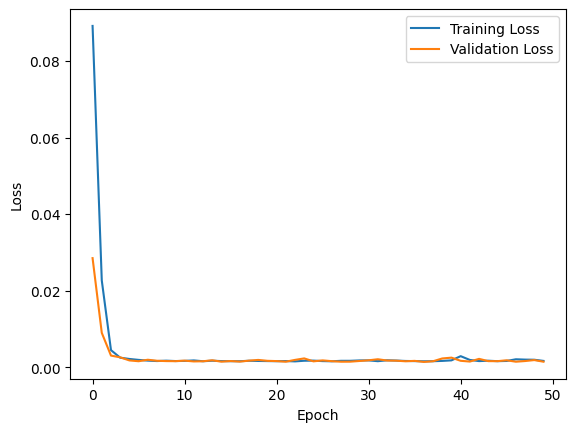

In [49]:
# Make predictions
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
predictions = scaler_y.inverse_transform(predictions_scaled)
y_seq_actual = scaler_y.inverse_transform(y_test)

# Plot the results
import matplotlib.pyplot as plt             # type: ignore

plt.figure(figsize=(14, 5))
plt.plot(y_seq_actual, color='blue', label='Actual Wait Time')
plt.plot(predictions, color='red', label='Predicted Wait Time')
plt.title('LSTM Model Prediction')
plt.xlabel('Time')
plt.ylabel('Wait Time')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
